In [1]:
from astropy.io import fits
import numpy as np

In [2]:
#Matplotlib configuration
from matplotlib import pyplot as plt

#A4 tufte layout paper figure sizes
MARGIN_FIG = lambda scale: (1.99, 1.99*scale)
MAIN_FIG = lambda scale: (4.18, 4.18*scale)
FULL_FIG = lambda scale: (6.64, 6.64*scale)

#Fontsize configuration
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', family='Fira Code')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#Other matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

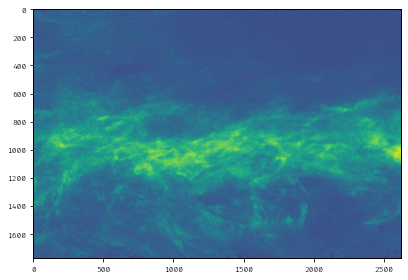

In [3]:
path = "../tmp/full_cube_smoothed-farfield.fits"
plane = fits.open(path)[0].data
plt.imshow(plane[182])
plt.show()

In [25]:
print(plane.shape)

(272, 1000, 2250)


In [4]:
#plot van de integrated density vs snelheid
N_CHANNELS = 272
V_STEP = -0.82446
V_REF = -60

#snelheid is TOV zon
v = np.linspace(0, V_STEP*N_CHANNELS, num=N_CHANNELS)
v = v - (v[145] - V_REF)

#gegokte begin/eindpunten van spiraalarmen
cygnus = (25, -25)
perseus = (-30, -50)
norma = (-65, -85)

#marginalised velocity
intensity = np.nansum(plane, (1, 2))
del plane

[-150. -125. -100.  -75.  -50.  -25.    0.   25.   50.]


C:\Users\rawol\AppData\Local\Temp\ipykernel_15108\1265290324.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


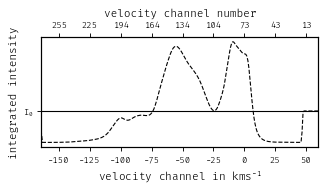

In [5]:
#make plot
fig = plt.figure(figsize=MAIN_FIG(0.6), dpi=80)
ax1 = fig.add_subplot(111)
ax1.plot(v, intensity, color='black', linestyle='--')

#zero axis
plt.axhline(0, color='black')
ax1.set_yticks([0], labels=['$I_0$'])

#arms
ax1.set_xlim(np.min(v), np.max(v))
ax1.set_xlabel("velocity channel in $kms^{-1}$")
ax1.set_ylabel("integrated intensity")

chans = np.arange(1, N_CHANNELS + 1)
def get_chnl(velocity):
  dv = abs(v - velocity)
  return f'{chans[np.where(dv == min(dv))][0]}'

x_ticks = ax1.get_xticks()[1:-1]
print(x_ticks)

#second axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_ticks, labels=[get_chnl(v) for v in x_ticks])
ax2.set_xlabel('velocity channel number')

#fix first axis?
ax1.set_xticks(x_ticks)

fig.savefig('../figs/integrated_intensity_2.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig.show()

In [10]:
#idee: fit gaussische verdelignen aan de pieken?
from scipy.optimize import curve_fit

def gauss(x, *p):
  A, mu, sigma = p
  return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#make guesses for the arms
p0_local = [2e8, 0, 25]
p0_outer = [2e8, -60, 20]

#limit v-range for arms
def limit_params(p0, v, I, tune=2):
  mu, sigma = p0[1], p0[2]
  v_lim = np.ma.masked_where((v <= (mu + tune*sigma)) & (v >= (mu - tune*sigma)), v, copy=True)
  I_lim = np.ma.masked_where((v <= (mu + tune*sigma)) & (v >= (mu - tune*sigma)), I, copy=True)
  return v_lim[v_lim.mask], I_lim[I_lim.mask]

v_local, I_local = limit_params(p0_local, v, intensity, tune=1.0)
v_outer, I_outer = limit_params(p0_outer, v, intensity, tune=1.5)

#fit gaussians
p_local, cov_local = curve_fit(gauss, v_local, I_local, p0=p0_local)
p_outer, cov_outer = curve_fit(gauss, v_outer, I_outer, p0=p0_outer)

print(f'local = {p_local}\n{cov_local}')
print(f'outer = {p_outer}\n{cov_outer}')

#berekende! begin/eindpunten van spiraalarmen
vr_local = (p_local[1] - 2*p_local[2], p_local[1] + 2*p_local[2])
vr_outer = (p_outer[1] - 2*p_outer[2], p_outer[1] + 2*p_outer[2])

print(vr_local)
print(vr_outer)

local = [ 1.10010886e+07 -6.22233903e+00 -6.89883893e+00]
[[7.52854878e+11 8.30103134e+02 3.16384365e+05]
 [8.30103134e+02 3.94453028e-01 1.19414545e-03]
 [3.16384365e+05 1.19414545e-03 3.97267198e-01]]
outer = [ 9.55006458e+06 -5.20972297e+01  1.12561854e+01]
[[ 4.97143311e+10 -1.66508679e+03 -4.15941105e+04]
 [-1.66508679e+03  9.25152792e-02  5.06637916e-03]
 [-4.15941105e+04  5.06637916e-03  1.00325843e-01]]
(7.57533882415381, -20.02001688454833)
(-74.60960053879, -29.584858783094703)


C:\Users\rawol\AppData\Local\Temp\ipykernel_15108\192779620.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(*vr_local, color='red', alpha=0.2, edgecolor=0.0)
C:\Users\rawol\AppData\Local\Temp\ipykernel_15108\192779620.py:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(*vr_outer, color='blue', alpha=0.2, edgecolor=0.0)


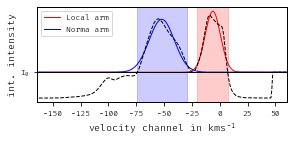

In [11]:
#plot de gausische verdelingen
plt.figure(figsize=MAIN_FIG(0.5))
plt.plot(v, intensity, color='black', linestyle='--', zorder=15)
plt.plot(v, gauss(v, *p_local), color='red', label='Local arm', linestyle='-')
plt.plot(v, gauss(v, *p_outer), color='blue', label='Norma arm', linestyle='-')
plt.legend()
plt.xlim(np.min(v), np.max(v))
plt.xlabel("velocity channel in $kms^{-1}$")
plt.ylabel("int. intensity")
plt.axhline(0, color='black')
plt.yticks([0], labels=['$I_0$'])

#arms
plt.axvspan(*vr_local, color='red', alpha=0.2, edgecolor=0.0)
plt.axvspan(*vr_outer, color='blue', alpha=0.2, edgecolor=0.0)

plt.savefig('../figs/three_gaussians_2.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
plt.show()